In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [2]:
### input an image and get the shape

(64, 64, 3)


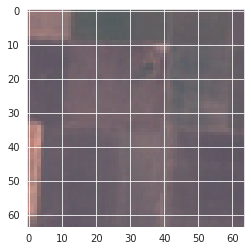

In [3]:
fpath=r'../input/eurosatland/archive (1)/2750/AnnualCrop/AnnualCrop_1.jpg'
img=plt.imread(fpath)
print (img.shape)
plt.imshow(img)

### read in cvs files

In [4]:
train_df=pd.read_csv(r'../input/eurosatland/train (1).csv')
test_df=pd.read_csv(r'../input/eurosatland/train (1).csv')
valid_df=pd.read_csv(r'../input/eurosatland/validation.csv')
print (train_df.head())
print (train_df['Label'].value_counts())
print (test_df.head())
print (test_df['Label'].value_counts())
print (valid_df.head())
print(valid_df['Label'].value_counts())
                    

   Unnamed: 0                                           Filename  Label  \
0       16257                      AnnualCrop/AnnualCrop_142.jpg      0   
1        3297  HerbaceousVegetation/HerbaceousVegetation_2835...      2   
2       17881               PermanentCrop/PermanentCrop_1073.jpg      6   
3        2223                      Industrial/Industrial_453.jpg      4   
4        4887  HerbaceousVegetation/HerbaceousVegetation_1810...      2   

              ClassName  
0            AnnualCrop  
1  HerbaceousVegetation  
2         PermanentCrop  
3            Industrial  
4  HerbaceousVegetation  
9    2100
7    2100
2    2100
1    2100
0    2100
8    1750
6    1750
4    1750
3    1750
5    1400
Name: Label, dtype: int64
   Unnamed: 0                                           Filename  Label  \
0       16257                      AnnualCrop/AnnualCrop_142.jpg      0   
1        3297  HerbaceousVegetation/HerbaceousVegetation_2835...      2   
2       17881               PermanentCrop/

In [5]:
df=pd.concat([train_df, test_df, valid_df],  axis=0).reset_index(drop=True)
print (df.head())
balance=df['Label'].value_counts()
print (balance)

   Unnamed: 0                                           Filename  Label  \
0       16257                      AnnualCrop/AnnualCrop_142.jpg      0   
1        3297  HerbaceousVegetation/HerbaceousVegetation_2835...      2   
2       17881               PermanentCrop/PermanentCrop_1073.jpg      6   
3        2223                      Industrial/Industrial_453.jpg      4   
4        4887  HerbaceousVegetation/HerbaceousVegetation_1810...      2   

              ClassName  
0            AnnualCrop  
1  HerbaceousVegetation  
2         PermanentCrop  
3            Industrial  
4  HerbaceousVegetation  
9    4800
7    4800
2    4800
1    4800
0    4800
8    4000
6    4000
4    4000
3    4000
5    3200
Name: Label, dtype: int64


### create train, test and valid dataframes

In [6]:
train_split=.9
valid_split=.05
dummy_split=valid_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('length train_df: ', len(train_df), '  length test_df: ', len(test_df), '  length valid_df: ', len(valid_df))
balance=train_df['Label'].value_counts()
print (balance)

length train_df:  38880   length test_df:  2160   length valid_df:  2160
0    4360
9    4338
2    4324
1    4312
7    4294
8    3615
6    3610
3    3602
4    3586
5    2839
Name: Label, dtype: int64


### dataset is not balanced. Balance by having 2839 samples for each class

In [7]:
size=2839 # set number of samples for each class
samples=[]
group=train_df.groupby('Label')
for label in train_df['Label'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['Label'].value_counts())   
    sample=Lgroup.sample(size, axis=0)
    samples.append(sample) 
train_df=pd.concat(samples, axis=0).reset_index(drop=True)
print (len(df))     
print (train_df['Label'].value_counts())  

43200
9    2839
8    2839
7    2839
6    2839
5    2839
4    2839
3    2839
2    2839
1    2839
0    2839
Name: Label, dtype: int64


### create train, test, valid  generators

In [8]:
sdir=r'../input/eurosatland/archive (1)/2750'
train_df['Label']=train_df['Label'].astype(str)
test_df['Label']=test_df['Label'].astype(str)
valid_df['Label']=valid_df['Label'].astype(str)
height=64
width=64
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator()
print('for the train generator')

train_gen=gen.flow_from_dataframe( train_df,sdir, x_col='Filename', y_col='Label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
print('for the test generator')
test_gen=gen.flow_from_dataframe( test_df, sdir, x_col='Filename', y_col='Label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
print('for the validation generator')
valid_gen=gen.flow_from_dataframe( valid_df, sdir, x_col='Filename', y_col='Label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  80   test steps:  27
for the train generator


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Found 28390 validated image filenames belonging to 10 classes.
for the test generator
Found 2160 validated image filenames belonging to 10 classes.
for the validation generator
Found 2160 validated image filenames belonging to 10 classes.


### create function to show some image examples

In [9]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

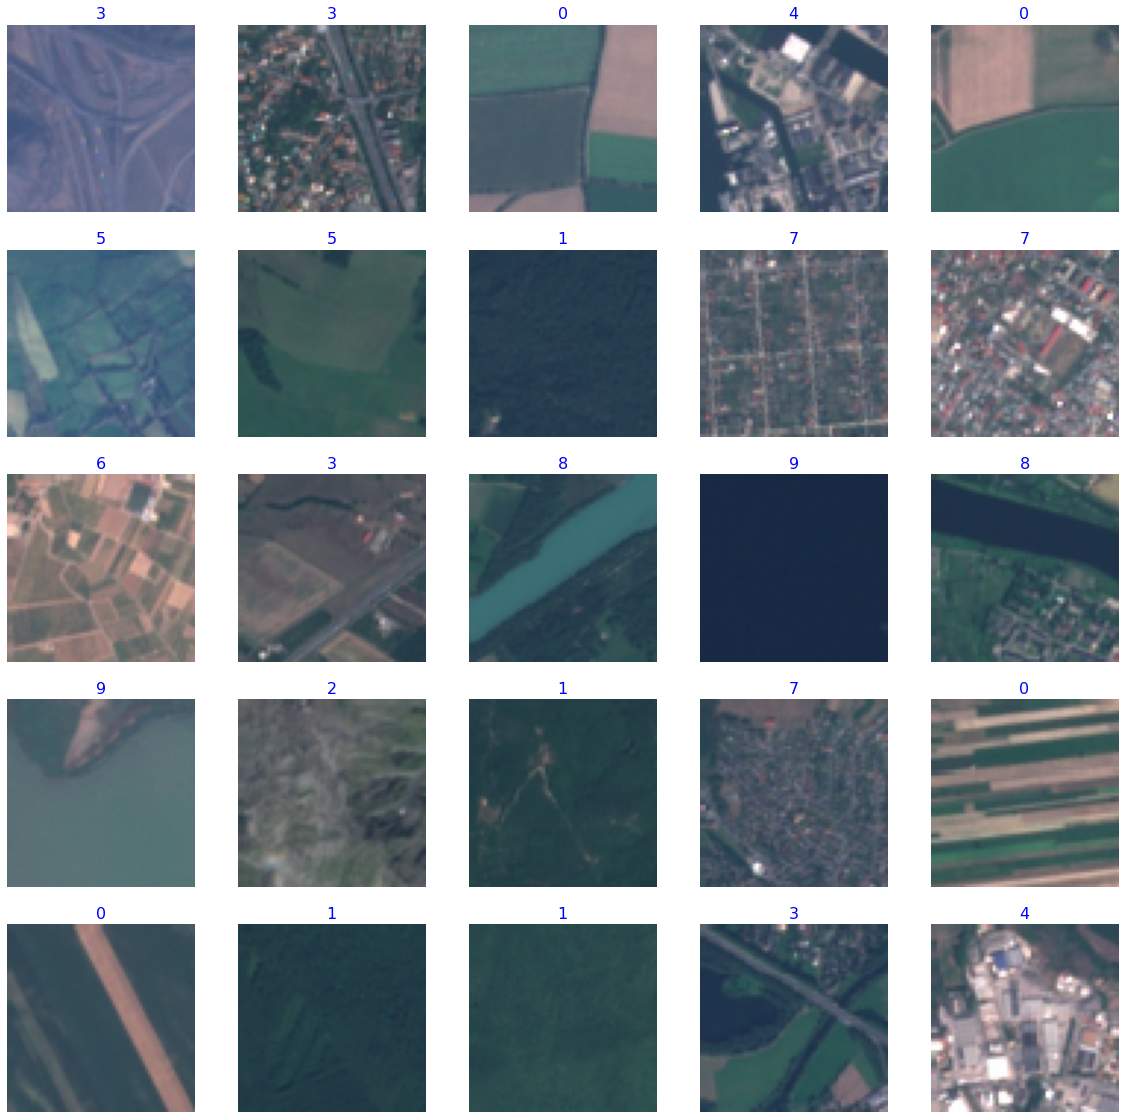

In [10]:
show_image_samples(train_gen)

### define function to print text in RGB foreground and background colors

In [11]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### create the model

In [12]:
model_name='EfficientNetB1'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

27025408/27018416 [==============================] - 0s 0us/step


### create a subclass of callbacks to control learning rate and print training results for each epoch

In [13]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration', 'Batch')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        
    def on_train_batch_begin(self, batch, logs=None):
        msg='{0:83s}{1:4s}of {2:5s}'.format(' ', str(batch), str(self.batches))
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

### instantiate the custom callback and train the model

In [14]:
epochs =10
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
batches=int(len(train_gen.labels)/batch_size)
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model EfficientNetB1 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

 1 /10     4.249   86.196   1.61481  97.315   0.00100  0.00100  accuracy   89.00  

 2 /10     1.001   94.586   0.48953  97.963   0.00100  0.00100  val_loss   50.42  

 3 /10     0.454   96.442   0.30163  98.194   0.00100  0.00100  val_loss   50.23  

 4 /10     0.326   97.376   0.23957  98.657   0.00100  0.00100  val_loss   50.60  

 5 /10     0.258   98.355   0.20326  99.028   0.00100  0.00100  val_loss   50.16  

 6 /10     0.224   98.693   0.18020  99.120   0.00100  0.00100  val_loss   50.18  

 7 /10     0.195   98.986   0.16862  99.120   0.00100  0.00100  val_loss   50.21  

 8 /10     0.178   99.105   0.16005  98.935   0.00100  0.00100  val_loss   50.02  

 9 /10     0.160   99.236   0.14635  99.213   0.00100  0.00100  val_loss   50.28  

10 /10     0.150   99.345   0.12850  99.398   0.00100  0.00100  val_loss   50.72

### define function to plot the training data

In [15]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define function to generate the confusion matrix and classification report

In [16]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

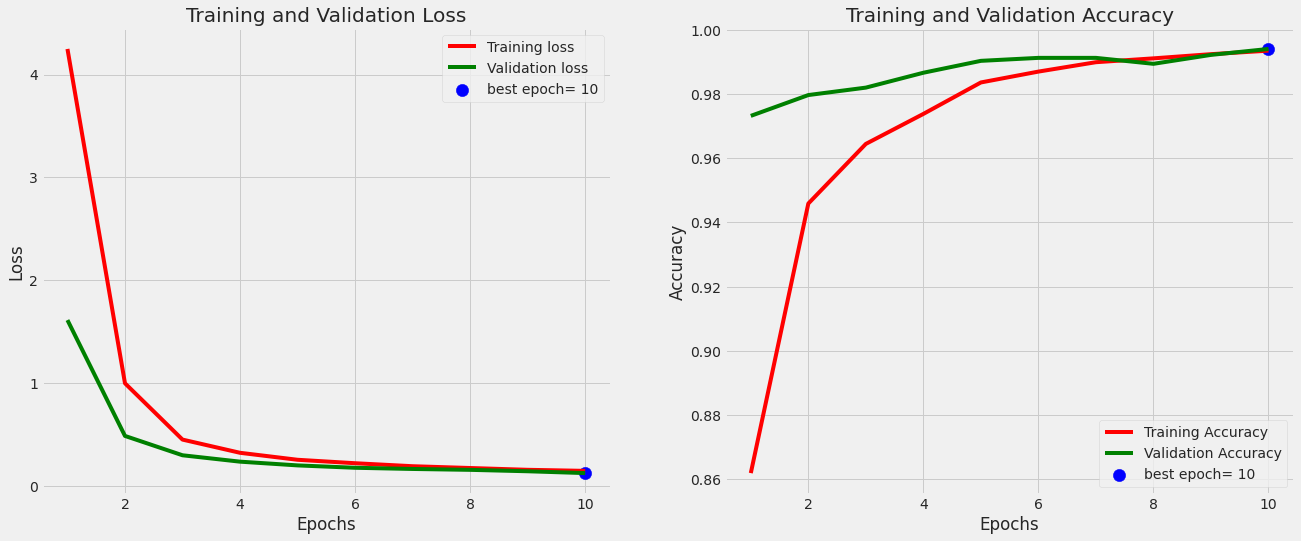

27/27 [==============================] - 4s 125ms/step - loss: 0.1440 - accuracy: 0.9898
accuracy on the test set is 98.98 %



In [17]:
tr_plot(history,0)
save_dir=r'./'
subject='land use'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### make predictions on test set and generate confusion matrix and classification report

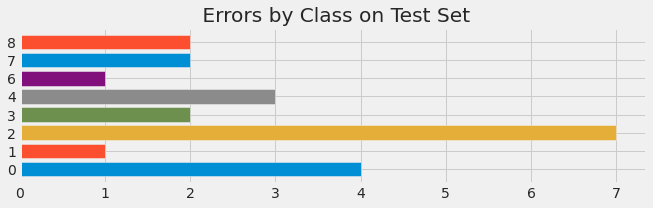

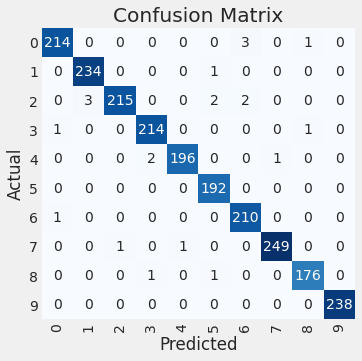

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       218
           1       0.99      1.00      0.99       235
           2       1.00      0.97      0.98       222
           3       0.99      0.99      0.99       216
           4       0.99      0.98      0.99       199
           5       0.98      1.00      0.99       192
           6       0.98      1.00      0.99       211
           7       1.00      0.99      0.99       251
           8       0.99      0.99      0.99       178
           9       1.00      1.00      1.00       238

    accuracy                           0.99      2160
   macro avg       0.99      0.99      0.99      2160
weighted avg       0.99      0.99      0.99      2160



In [18]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  